In this notebook, I will implement the SimCLR (*simple framework
for contrastive learning of visual representations*) model presented in following publication:
- Chen, Kornblith, Norouzi, Hinton, A Simple Framework for Contrastive Learning of Visual Representations. *arXiv* **2020**. https://arxiv.org/pdf/2002.05709.pdf

This model is meant to take advantage of situations in that labeled images are scarce but unlabeled images are not by using those unlabeled images for  contrastive self-supervised learning.

Here, we will be working with following dataset: 
- Maguire, M., Dorafshan, S., & Thomas, R. J. (2018). SDNET2018: A concrete crack image dataset for machine learning applications. Utah State University. https://doi.org/10.15142/T3TD19

Specifically, we will only work with wall images from the above data set. The data set in total contains 18138 images of walls and the goal is to predict if the wall in an image has a crack. In only 3851 of the images the wall has a crack, while in 14287 images it has not, meaning the data set is slightly imbalanced.

Please take note, that the implementation of SimCLR presented here, is in its current state not suited to be trained in a distributed fashion on multiple GPUs. As discussed in the original SimCLR paper from Chen et al., e.g. it is necessary to implement global batch normalization when training in a distributed fashion (as positive pairs are always located on the same GPU information leakage is possible...). See following link to get an idea how this global batch normalization might be implemented: 
- https://hangzhang.org/PyTorch-Encoding/_modules/encoding/nn/syncbn.html#DistSyncBatchNorm

Also, the NTXent loss would need to be adapted before training in a distributed fashion. See following links to get an idea how this might be done:
- https://github.com/KevinMusgrave/pytorch-metric-learning/issues/380
- https://kevinmusgrave.github.io/pytorch-metric-learning/distributed/

Also take note, that multiple decisions taken in this notebook are not optimal for achieving the best result but were made in order to keep execution time short.

With that said, let' start by installing and import the necessary libraries:

In [1]:
!pip install pytorch_metric_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 15.0 MB/s 


In [2]:
import urllib
import zipfile
import os
import ssl
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, Conv2d, Sequential, ReLU, BatchNorm2d, MaxPool2d, AdaptiveMaxPool2d
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiplicativeLR
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score
from sklearn.metrics import accuracy_score
from functools import partial
import albumentations as A
from torchsummary import summary
from pytorch_metric_learning.losses import NTXentLoss

random.seed(1)
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Let's download the data set:

In [3]:
ssl._create_default_https_context = ssl._create_unverified_context
url = "https://digitalcommons.usu.edu/cgi/viewcontent.cgi?filename=2&article=1047&context=all_datasets&type=additional"
data_dir = "./data"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(data_dir)
    
files_walls_c = next(os.walk(data_dir + "/W/CW"))[2]
files_walls_c = [(data_dir + "/W/CW/" + x) for x in files_walls_c]
files_walls_u = next(os.walk(data_dir + "/W/UW"))[2]
files_walls_u = [(data_dir + "/W/UW/" + x) for x in files_walls_u]

files_walls = files_walls_c + files_walls_u
random.shuffle(files_walls)

...And have a peak at the data set by displaying an image of a cracked and a uncracked wall:

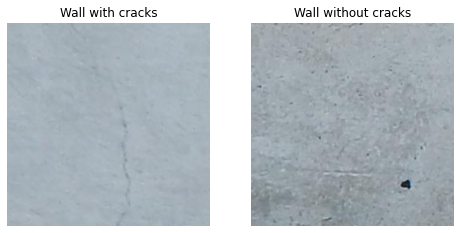

In [4]:
img1 = np.array(Image.open(files_walls_c[0]))
img2 = np.array(Image.open(files_walls_u[0]))


fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(img1)
ax[0].set_title("Wall with cracks")
ax[1].imshow(img2)
ax[1].set_title("Wall without cracks")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

To establish a baseline for the SimCLR model, we will first train a CNN model in classical, supervised fashion. For this, we will implement a dataset class that is meant to yield both image and label:

In [5]:
class WallDatasetSupervised(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        img = np.array(Image.open(file_path)) / 255
        img = np.moveaxis(img, 2, 0)       
        img = torch.tensor(img).float()

        if "CW" in file_path:
            y = torch.tensor([0, 1]).float()
        elif "UW" in file_path:
            y = torch.tensor([1, 0]).float()
        return img, y

And a simple CNN class that is also meant for supervised learning:

In [6]:
class BaseCNN(nn.Module):
    def __init__(self, img_shape, no_classes, filter_sizes_conv_block, 
                 kernel_sizes_ffn_block):
        super(BaseCNN, self).__init__()
        self.img_shape = img_shape
        self.no_classes = no_classes
        self.filter_sizes_conv_block = filter_sizes_conv_block
        self.kernel_sizes_ffn_block = kernel_sizes_ffn_block
        self.conv_block = self._create_conv_block(filter_sizes_conv_block)
        self.dropout = nn.Dropout(p=0.4)
        self.ffn_block = self._create_ffn_block(kernel_sizes_ffn_block)
        self.softmax = nn.Softmax(dim=-1)
    
    def _create_conv_block(self, filter_sizes, kernel_size=3):
        filter_sizes.insert(0, self.img_shape[0])
        modules = []
        for i in range(len(filter_sizes) - 1):
            modules.append(BatchNorm2d(filter_sizes[i]))
            modules.append(Conv2d(
                in_channels=filter_sizes[i], 
                out_channels=filter_sizes[i+1],
                kernel_size=kernel_size, 
                stride=1, 
                padding="same"))
            modules.append(ReLU())
            if i != len(filter_sizes) - 2:
                modules.append(MaxPool2d((2, 2)))
        return Sequential(*modules)
    
    def _create_ffn_block(self, kernel_network, extend_kernel_network=True):
        if extend_kernel_network:
            kernel_network.append(self.no_classes)
            kernel_network.insert(0, self.filter_sizes_conv_block[-1])
        
        modules = []
        for i in range(len(kernel_network) - 1):
            modules.append(Linear(kernel_network[i], kernel_network[i+1]))
            if i != len(kernel_network) - 2:
                modules.append(ReLU())
        return Sequential(*modules)
    
    def forward(self, x):
        x = self.conv_block(x)
        x = F.max_pool2d(x, kernel_size=x.size()[2])
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = self.ffn_block(x)
        x = self.softmax(x)
        return x


cnn001 = BaseCNN((3, 256, 256), 2, [32, 32, 64], [64])
cnn001.to(device)
summary(cnn001, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 256, 256]               6
            Conv2d-2         [-1, 32, 256, 256]             896
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
       BatchNorm2d-5         [-1, 32, 128, 128]              64
            Conv2d-6         [-1, 32, 128, 128]           9,248
              ReLU-7         [-1, 32, 128, 128]               0
         MaxPool2d-8           [-1, 32, 64, 64]               0
       BatchNorm2d-9           [-1, 32, 64, 64]              64
           Conv2d-10           [-1, 64, 64, 64]          18,496
             ReLU-11           [-1, 64, 64, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                   [-1, 64]           4,160
             ReLU-14                   

Now we beginn to split the data set. Of the 18138 images in the data set, we will only use 4000 images with their labels for supervised learning. The remaining 14138 images will be used for self-supervised learning without knowing their label. The 4000 images with labels will be split into a training (1200 images), validation (1200 images), and test (1600 images) data set:

In [7]:
def split_data(data, train_ratio, val_ratio):
    test_ratio = 1 - train_ratio - val_ratio
    no_train_samples = int(len(data) * train_ratio)
    no_test_samples =  int(len(data) * test_ratio)
    
    train_data = random.sample(data, no_train_samples)
    val_data = [x for x in data if x not in train_data]
    test_data = random.sample(val_data, no_test_samples)
    val_data = [x for x in val_data if x not in test_data]
    return train_data, val_data, test_data
    
    
files_train_supervised, files_val_supervised, files_test_supervised = \
    split_data(files_walls[0:4000], 0.3, 0.3)

dataset_train_supervised = WallDatasetSupervised(files_train_supervised)
dataset_val_supervised = WallDatasetSupervised(files_val_supervised)
dataset_test_supervised = WallDatasetSupervised(files_test_supervised)

batch_size = 128
dataloader_train_supervised = DataLoader(
    dataset_train_supervised, batch_size=batch_size, shuffle=True, 
    num_workers=2, pin_memory=True)
dataloader_val_supervised = DataLoader(
    dataset_val_supervised, batch_size=batch_size, shuffle=False, 
    num_workers=2, pin_memory=True)
dataloader_test_supervised = DataLoader(
    dataset_test_supervised, batch_size=batch_size, shuffle=False, 
    num_workers=2, pin_memory=True)

We implement a trainer class that is meant to handle all aspects of supervised training:

In [8]:
class Trainer:
    def __init__(self, model, path_saved_model=None):
        self.model = model
        self._reset_model()
        if path_saved_model is not None:
            self._load_model(path_saved_model)
            
    def _reset_loss_history(self):
        self.train_loss_hist = []
        self.val_loss_hist = []
        
    def _reset_model(self):    
        for layer in self.model.children():
            if hasattr(layer, "reset_parameters"):
                layer.reset_parameters()
                
    def optimize(self, max_epochs, train_loader, val_loader, lr=1e-3, 
                 lr_decay=1, patience=8, path="./model"):
        self._reset_loss_history()
        self._reset_model()
        self.model.to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = MultiplicativeLR(
            optimizer=self.optimizer, lr_lambda=lambda epoch: lr_decay)
        
        for epoch in range(0, max_epochs):
            t_start = time.time()
            train_loss = self._train_supervised(train_loader)
            val_loss = self._validate_supervised(val_loader)
            t_end = time.time()
            
            self._logging(
                epoch, train_loss, val_loss, (t_end - t_start))            
            
            self.scheduler.step()
            if epoch > 0:
                if self.val_loss_hist[-1] < min(self.val_loss_hist[:-1]):
                    self._save_model(path)
                    print("Saving model")
            if epoch > patience:
                if (min(self.val_loss_hist[-patience:]) > 
                    min(self.val_loss_hist[:-patience])):
                    print("Early stopping")
                    break
        self.epochs = list(range(epoch+1))
        self._plot_optimization_progress()
        self._load_model(path)
    
    def _train_supervised(self, loader):
        self.model.train()
        sum_of_losses = 0
        for batch_idx, (X, y) in enumerate(loader):
            X = X.to(device)
            y = y.to(device)
            self.optimizer.zero_grad()
            y_pred = self.model(X)
            loss = F.binary_cross_entropy(y_pred, y)
            loss.backward()
            self.optimizer.step()
            sum_of_losses += loss.detach().cpu().numpy()
        return sum_of_losses / (len(loader.dataset) + 1)
    
    def _validate_supervised(self, loader):
        self.model.eval()
        sum_of_losses = 0
        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(loader):
                X = X.to(device)
                y = y.to(device)
                y_pred = self.model(X)
                loss = F.binary_cross_entropy(y_pred, y)
                sum_of_losses += loss.detach().cpu().numpy()
        return sum_of_losses / (len(loader.dataset) + 1)    
    
    def _logging(self, epoch, train_loss, val_loss, time):
        self.train_loss_hist.append(train_loss)
        self.val_loss_hist.append(val_loss)
        print(f"""\
Epoch: {str(epoch).zfill(3)}, Train loss: {self.train_loss_hist[-1]:.3E}, \
Validation loss: {self.val_loss_hist[-1]:.3E}, \
Time: {str(int(time)).zfill(4)} s, Learning rate: \
{self.optimizer.param_groups[0]["lr"]:.2E}.""")

    def _plot_optimization_progress(self):
        fig, ax = plt.subplots()
        ax.plot(
            self.epochs, self.train_loss_hist, color="b", label="Training")
        ax.plot(self.epochs, self.val_loss_hist, color="r", label="Validation")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.legend()        
        plt.show()
    
    def _save_model(self, path):
        torch.save(self.model.state_dict(), path)
    
    def _load_model(self, path): 
        self.model.load_state_dict(torch.load(path))

And then train our baseline CNN in a supervised fashion:

Epoch: 000, Train loss: 5.267E-03, Validation loss: 5.624E-03, Time: 0007 s, Learning rate: 8.00E-04.
Epoch: 001, Train loss: 4.333E-03, Validation loss: 4.696E-03, Time: 0006 s, Learning rate: 7.68E-04.
Saving model
Epoch: 002, Train loss: 4.180E-03, Validation loss: 4.351E-03, Time: 0006 s, Learning rate: 7.37E-04.
Saving model
Epoch: 003, Train loss: 4.041E-03, Validation loss: 4.377E-03, Time: 0006 s, Learning rate: 7.08E-04.
Epoch: 004, Train loss: 4.035E-03, Validation loss: 4.250E-03, Time: 0007 s, Learning rate: 6.79E-04.
Saving model
Epoch: 005, Train loss: 4.094E-03, Validation loss: 4.104E-03, Time: 0007 s, Learning rate: 6.52E-04.
Saving model
Epoch: 006, Train loss: 3.956E-03, Validation loss: 4.045E-03, Time: 0007 s, Learning rate: 6.26E-04.
Saving model
Epoch: 007, Train loss: 3.989E-03, Validation loss: 4.005E-03, Time: 0006 s, Learning rate: 6.01E-04.
Saving model
Epoch: 008, Train loss: 3.881E-03, Validation loss: 4.000E-03, Time: 0007 s, Learning rate: 5.77E-04.
Savi

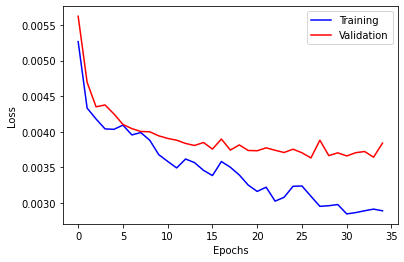

In [9]:
trainer_supervised = Trainer(cnn001)
trainer_supervised.optimize(150, dataloader_train_supervised, 
                            dataloader_val_supervised, lr=8e-4, lr_decay=0.96)

Now, we will evaluate the baseline model. Next to the accuracy score, we will also look at the confusion matrix and the GBA score (will be explained in a second). Because the data set in imbalanced, accuracy is misleading as a metric. For example, our model might achieve an accuracy of 14287 / 18138 ≈ 79% by simply always predicting that the wall shown in the image has no crack. Other metrics, e.g. the F1 score, although they were meant to be for imbalanced data sets, are misleading too. The F1 score will still be larger than zero if the model simply always predicts that the wall shown in the image has no crack. This gives a false idea that the model has learned anything useful. As pointed out in following publication:
- Zhu, On the Performance of Matthews Correlation Coefficient (MCC) for
Imbalanced Dataset. *Pattern Recognition Letters* **2020**, https://doi.org/10.1016/j.patrec.2020.03.030

the GBA score is better suited in such a situation. It is defined as: $\sqrt{true\:positive\:rate * true\:negative\:rate}$

Accuracy: 0.834
GBA score: 0.552


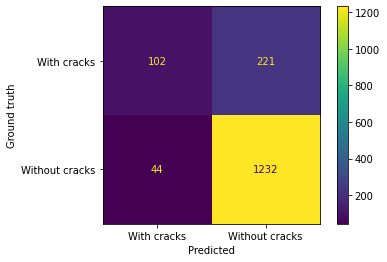

In [10]:
def gba_score(y_true, y_pred):
    true_positive = np.sum((y_true == 0) & (y_pred == 0))
    true_negative = np.sum((y_true == 1) & (y_pred == 1))
    false_positive = np.sum((y_true == 1) & (y_pred == 0))
    false_negative = np.sum((y_true == 0) & (y_pred == 1))
    
    true_positive_rate = true_positive / (true_positive + false_negative)
    true_negative_rate = true_negative / (true_negative + false_positive)
    
    gba = (true_positive_rate * true_negative_rate)**0.5
    return gba
    
    
def test_model(model, dataloader):
    model.eval()
    
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            y_test_pred_prob = model(X)
            if batch_idx == 0:
                y_test_pred_probs = y_test_pred_prob
                y_test = y
            else:
                y_test_pred_probs = torch.cat(
                    [y_test_pred_probs, y_test_pred_prob], dim=0)
                y_test = torch.cat([y_test, y], dim=0)
        y_test_pred_probs = y_test_pred_probs.cpu().numpy()
        y_test = y_test.cpu().numpy()
        
    y_test_pred = np.where(y_test_pred_probs[:,0] > 0.5, 1, 0)
    y_test = np.where(y_test[:, 0], 1, 0)
    
    accuracy = accuracy_score(y_test, y_test_pred)
    gba = gba_score(y_test, y_test_pred)
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"GBA score: {gba:.3f}")
    cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xticks([0,1], ["With cracks", "Without cracks"])
    plt.yticks([0,1], ["With cracks", "Without cracks"])
    plt.ylabel("Ground truth")
    plt.xlabel("Predicted")
    plt.show()

test_model(trainer_supervised.model, dataloader_test_supervised)

Now, for our SimCLR approach we train in a self-supervised, contrastive modus and therefore need a slightly different data set class than before. The data set class implemented below outputs two different augmented images of the same original image. For a clearer understanding, we will visualize an example output of the data set class below. We also implement the corresponding dataloaders below. Please take note that SimCLR benefits from larger batch sizes, so it might be worth to increase the batch size even further:

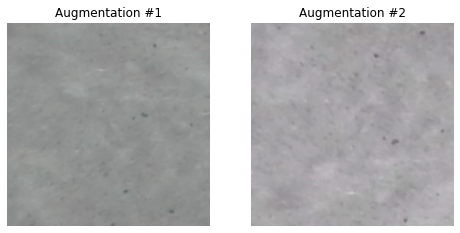

In [11]:
class WallDatasetCLR(WallDatasetSupervised):
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        img = np.array(Image.open(file_path))
        img1, img2 = self.augment(img), self.augment(img)

        img1 = torch.tensor(np.moveaxis(img1 / 255, 2, 0)).float()
        img2 = torch.tensor(np.moveaxis(img2 / 255, 2, 0)).float()
        return img1, img2
    
    def augment(self, img):
        transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomCrop(
                width=int(img.shape[1] * random.uniform(0.85, 1)), 
                height=int(img.shape[0] * random.uniform(0.85, 1))),
            A.Resize(img.shape[0], img.shape[1]),
            A.ColorJitter(p=0.75),
            ])
        transformed = transform(image=img)
        return transformed["image"]
    

files_clr = files_train_supervised + files_val_supervised + files_walls[4000:]
files_train_clr, files_val_clr, _ = split_data(files_clr, 0.8, 0.2)

dataset_train_clr = WallDatasetCLR(files_train_clr)
dataset_val_clr = WallDatasetCLR(files_val_clr)

img3, img4 = dataset_train_clr[0]
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(np.moveaxis(img3.numpy(), 0, 2))
ax[0].set_title("Augmentation #1")
ax[1].imshow(np.moveaxis(img4.numpy(), 0, 2))
ax[1].set_title("Augmentation #2")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

batch_size = 128 
dataloader_train_clr = DataLoader(
    dataset_train_clr, batch_size=batch_size, shuffle=True, num_workers=2, 
    pin_memory=True)
dataloader_val_clr = DataLoader(
    dataset_val_clr, batch_size=batch_size, shuffle=True, num_workers=2, 
    pin_memory=True)

Now, we implement our SimCLR model. The SimCLR extends our baseline CNN by a projection head. The implementation below contains a switch so that after self-supervised learning the learned weights & biases can be used for transfer learning in a supervised fashion. There is also functionality to freeze the convolutional layers during the initial epochs of this transfer learning. 

In [12]:
class SimCLR(BaseCNN):
    def __init__(self, img_shape, no_classes, filter_sizes_conv_block, 
                 kernel_sizes_ffn_block, projection_head_output_dims):
        super().__init__(img_shape, no_classes, filter_sizes_conv_block, 
                         kernel_sizes_ffn_block)
        self.projection_head_output_dims = projection_head_output_dims
        self.projection_head = self._create_projection_head()
        
    @property
    def clr_modus(self):
        return self._clr_modus
    
    @clr_modus.setter
    def clr_modus(self, value):
        assert(type(value) == bool)
        if value:
            print("Switching to contrastive learning modus...")
            self.dropout = nn.Identity()
            self.ffn_block = nn.Identity()
            self.softmax = nn.Identity()
        else:
            print("Switching to supervised learning modus...")
            self.dropout = nn.Dropout(p=0.4)
            self.ffn_block = self._create_ffn_block(
                self.kernel_sizes_ffn_block, extend_kernel_network=False)
            self.softmax = nn.Softmax(dim=-1)
        self._clr_modus = value
       
    def _create_projection_head(self):
        modules = []
        modules.append(Linear(
            self.filter_sizes_conv_block[-1], self.projection_head_output_dims))
        modules.append(ReLU())      
        return Sequential(*modules)
    
    def forward(self, x):
        x = super().forward(x.to(device))
        if self._clr_modus:
            x = self.projection_head(x)
        return x
    
    def _freeze_conv_block(self):
        for p in self.conv_block.parameters():
            p.requires_grad = False
        print("Freezing conv_block")
    
    def _unfreeze_conv_block(self):
        for p in self.conv_block.parameters():
            p.requires_grad = True
        print("Unfreezing conv_block")
            

cnn002 = SimCLR((3, 256, 256), 2, [32, 32, 64], [64], 128)

To demonstrate the switch discussed above, let us look at our network before triggering the switch:

In [13]:
cnn002.clr_modus = True
cnn002.to(device)
summary(cnn002, (3, 256, 256))

Switching to contrastive learning modus...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 256, 256]               6
            Conv2d-2         [-1, 32, 256, 256]             896
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
       BatchNorm2d-5         [-1, 32, 128, 128]              64
            Conv2d-6         [-1, 32, 128, 128]           9,248
              ReLU-7         [-1, 32, 128, 128]               0
         MaxPool2d-8           [-1, 32, 64, 64]               0
       BatchNorm2d-9           [-1, 32, 64, 64]              64
           Conv2d-10           [-1, 64, 64, 64]          18,496
             ReLU-11           [-1, 64, 64, 64]               0
         Identity-12                   [-1, 64]               0
         Identity-13                   [-1, 64]             

...and after triggering the switch:

In [14]:
cnn002.clr_modus = False
cnn002.to(device)
summary(cnn002, (3, 256, 256))

Switching to supervised learning modus...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 256, 256]               6
            Conv2d-2         [-1, 32, 256, 256]             896
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
       BatchNorm2d-5         [-1, 32, 128, 128]              64
            Conv2d-6         [-1, 32, 128, 128]           9,248
              ReLU-7         [-1, 32, 128, 128]               0
         MaxPool2d-8           [-1, 32, 64, 64]               0
       BatchNorm2d-9           [-1, 32, 64, 64]              64
           Conv2d-10           [-1, 64, 64, 64]          18,496
             ReLU-11           [-1, 64, 64, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                   [-1, 64]           4,1

We implement a trainer class that is meant to handle both training of our SimCLR model in self-supervised modus as well as transfer learning in a supervised modus:

In [15]:
class SimCLRTrainer(Trainer):
    def __init__(self, model, path_saved_model=None):
        super().__init__(model, path_saved_model)
        
    def optimize(self, max_epochs, train_loader, val_loader, lr=1e-3, 
                 lr_decay=1, patience=8, path="./model", clr_modus=True, 
                 temperature=0.05, freeze_conv_block_for_x_epochs=10):
        self._reset_loss_history()
        self.loss = NTXentLoss(temperature=temperature)

        if clr_modus:
            self._reset_model()
            self.model.clr_modus = True
        else:
            self.model.clr_modus = False
            self.model._freeze_conv_block()
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = MultiplicativeLR(
            optimizer=self.optimizer, lr_lambda=lambda epoch: lr_decay)
        self.model.to(device)       

        for epoch in range(0, max_epochs):
            t_start = time.time()
            if clr_modus:
                train_loss = self._train_clr(train_loader, temperature)
                val_loss = self._validate_clr(val_loader, temperature)
            else:
                train_loss = self._train_supervised(train_loader)
                val_loss = self._validate_supervised(val_loader)
            t_end = time.time()
            
            self._logging(
                epoch, train_loss, val_loss, (t_end - t_start))            
            self.scheduler.step()
            
            if epoch > 0:
                if self.val_loss_hist[-1] < min(self.val_loss_hist[:-1]):
                    self._save_model(path)
                    print("Saving model")
            if clr_modus == False:
                if epoch == freeze_conv_block_for_x_epochs - 1:
                    self.model._unfreeze_conv_block()
                    self.optimizer = optim.Adam(
                        self.model.parameters(), 
                        lr=self.optimizer.param_groups[0]["lr"])
                    self.scheduler = MultiplicativeLR(
                        optimizer=self.optimizer, 
                        lr_lambda=lambda epoch: lr_decay)
            if epoch > patience:
                if (min(self.val_loss_hist[-patience:]) > 
                    min(self.val_loss_hist[:-patience])):
                    print("Early stopping")
                    break
        self.epochs = list(range(epoch+1))
        self._plot_optimization_progress()
        self._load_model(path)
    
    def _train_clr(self, loader, temperature):
        self.model.train()
        sum_of_losses = 0
        for batch_idx, (X_i, X_j) in enumerate(loader):
            X_i = X_i.to(device)
            X_j = X_j.to(device)
            self.optimizer.zero_grad()
            z_i = self.model(X_i)
            z_j = self.model(X_j)
            loss = self._calculate_NTXent_loss(z_i, z_j)
            loss.backward()
            self.optimizer.step()
            sum_of_losses += loss.detach().cpu().numpy()
        return sum_of_losses / (len(loader.dataset) + 1)
    
    def _validate_clr(self, loader, temperature):
        self.model.eval()
        sum_of_losses = 0
        with torch.no_grad():
            for batch_idx, (X_i, X_j) in enumerate(loader):
                X_i = X_i.to(device)
                X_j = X_j.to(device)
                z_i = self.model(X_i)
                z_j = self.model(X_j)
                loss = self._calculate_NTXent_loss(z_i, z_j)
                sum_of_losses += loss.detach().cpu().numpy()
        return sum_of_losses / (len(loader.dataset) + 1)      
        
    def _calculate_NTXent_loss(self, z_i, z_j):       
        embeddings = torch.cat((z_i, z_j))
        indices = torch.arange(0, z_i.size(0))
        labels = torch.cat((indices, indices))
        return self.loss(embeddings, labels)

Now, we will first train our model in a self-supervised fashion:

Switching to contrastive learning modus...
Epoch: 000, Train loss: 1.754E-02, Validation loss: 1.168E-02, Time: 0119 s, Learning rate: 2.00E-03.
Epoch: 001, Train loss: 1.036E-02, Validation loss: 8.758E-03, Time: 0119 s, Learning rate: 1.98E-03.
Saving model
Epoch: 002, Train loss: 8.188E-03, Validation loss: 7.736E-03, Time: 0119 s, Learning rate: 1.96E-03.
Saving model
Epoch: 003, Train loss: 7.237E-03, Validation loss: 7.580E-03, Time: 0119 s, Learning rate: 1.94E-03.
Saving model
Epoch: 004, Train loss: 6.829E-03, Validation loss: 6.126E-03, Time: 0121 s, Learning rate: 1.92E-03.
Saving model
Epoch: 005, Train loss: 6.040E-03, Validation loss: 5.945E-03, Time: 0120 s, Learning rate: 1.90E-03.
Saving model
Epoch: 006, Train loss: 5.545E-03, Validation loss: 5.508E-03, Time: 0118 s, Learning rate: 1.88E-03.
Saving model
Epoch: 007, Train loss: 5.159E-03, Validation loss: 5.657E-03, Time: 0120 s, Learning rate: 1.86E-03.
Epoch: 008, Train loss: 4.922E-03, Validation loss: 4.695E-03, 

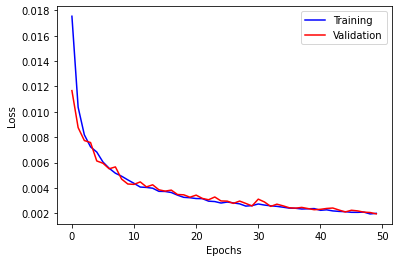

In [16]:
simclr_trainer = SimCLRTrainer(cnn002)     
simclr_trainer.optimize(
    max_epochs=50, train_loader=dataloader_train_clr, 
    val_loader=dataloader_val_clr, lr=2e-3, lr_decay=0.99, patience=8, 
    path="./model_clr", clr_modus=True)

And then use the learned weights & biases for transfer learning:

Switching to supervised learning modus...
Freezing conv_block
Epoch: 000, Train loss: 1.068E-02, Validation loss: 7.294E-03, Time: 0006 s, Learning rate: 8.00E-04.
Epoch: 001, Train loss: 8.058E-03, Validation loss: 4.548E-03, Time: 0006 s, Learning rate: 7.84E-04.
Saving model
Epoch: 002, Train loss: 6.291E-03, Validation loss: 4.467E-03, Time: 0006 s, Learning rate: 7.68E-04.
Saving model
Epoch: 003, Train loss: 5.568E-03, Validation loss: 4.325E-03, Time: 0006 s, Learning rate: 7.53E-04.
Saving model
Epoch: 004, Train loss: 5.140E-03, Validation loss: 3.970E-03, Time: 0006 s, Learning rate: 7.38E-04.
Saving model
Epoch: 005, Train loss: 4.942E-03, Validation loss: 3.893E-03, Time: 0006 s, Learning rate: 7.23E-04.
Saving model
Epoch: 006, Train loss: 4.807E-03, Validation loss: 4.073E-03, Time: 0006 s, Learning rate: 7.09E-04.
Epoch: 007, Train loss: 4.422E-03, Validation loss: 3.848E-03, Time: 0006 s, Learning rate: 6.95E-04.
Saving model
Epoch: 008, Train loss: 4.401E-03, Validatio

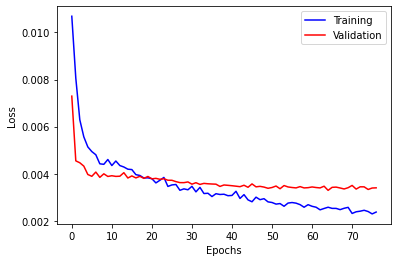

In [17]:
simclr_trainer.optimize(
    max_epochs=100, train_loader=dataloader_train_supervised, 
    val_loader=dataloader_val_supervised, lr=8e-4, lr_decay=0.98, patience=12, 
    path="./model_supervised", clr_modus=False, 
    freeze_conv_block_for_x_epochs=15)

Finally, we evaluate the performance of this model and can see that the SimCLR approach significantly outperforms our baseline CNN:

Accuracy: 0.856
GBA score: 0.621


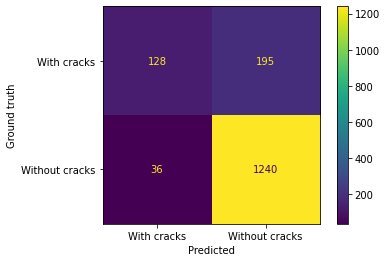

In [18]:
test_model(simclr_trainer.model, dataloader_test_supervised)